In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# read the pickle file
with open('../tracker_stubs/ball_detections.pkl', 'rb') as f:
    ball_positions = pickle.load(f)

In [3]:
ball_positions = [x.get(1, []) for x in ball_positions] # None detect for [] return
# Convert the list into pandas dataframe
df_ball_positions = pd.DataFrame(ball_positions,columns=['x1','y1','x2','y2'])

# Interpolate the missing values between multi frames
df_ball_positions = df_ball_positions.interpolate()
df_ball_positions = df_ball_positions.bfill() # For edge case

In [4]:
df_ball_positions['mid_y'] = (df_ball_positions['y1'] + df_ball_positions['y2'])/2
df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['mid_y'].rolling(window=5, min_periods=1, center=False).mean() # smooth out short-term 波動

Text(0, 0.5, 'Rolling Mean Y')

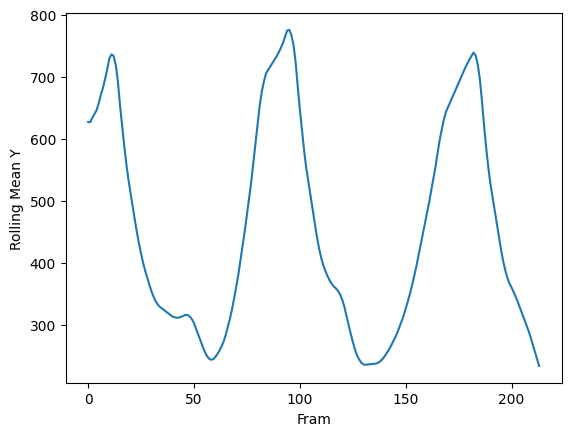

In [5]:
# plot mid_y_rolling_mean
plt.plot(df_ball_positions['mid_y_rolling_mean'])
plt.xlabel('Fram')
plt.ylabel('Rolling Mean Y')

In [6]:
# Get y's movement
df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff()

Text(0, 0.5, 'Delta Y')

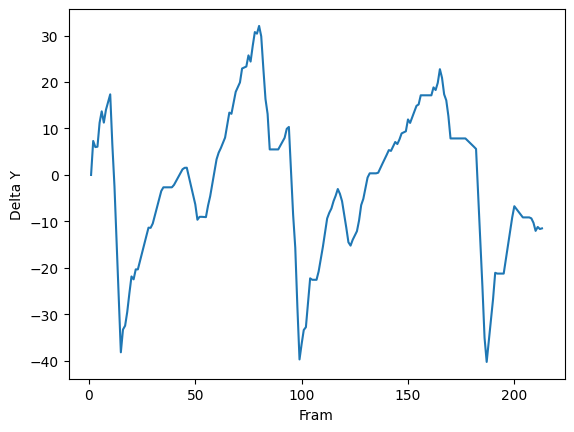

In [7]:

plt.plot(df_ball_positions['delta_y'])
plt.xlabel('Fram')
plt.ylabel('Delta Y')

In [8]:

df_ball_positions['ball_hit']=0
ball_hit_index = []

In [9]:
minimum_change_frames_for_hit = 25
for i in range(1, len(df_ball_positions) - int(minimum_change_frames_for_hit*1.2) ):
    # Check changes
    negative_position_change = df_ball_positions['delta_y'].iloc[i] >0 and df_ball_positions['delta_y'].iloc[i+1] <0
    positive_position_change = df_ball_positions['delta_y'].iloc[i] <0 and df_ball_positions['delta_y'].iloc[i+1] >0
    
    # Check if changes count over threshold(minimum_change_frames_for_hit)
    if negative_position_change or positive_position_change:
        change_count = 0 
        for change_frame in range(i+1, i+int(minimum_change_frames_for_hit*1.2)+1):
            negative_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] >0 and df_ball_positions['delta_y'].iloc[change_frame] <0
            positive_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] <0 and df_ball_positions['delta_y'].iloc[change_frame] >0

            if negative_position_change and negative_position_change_following_frame:
                change_count+=1
            elif positive_position_change and positive_position_change_following_frame:
                change_count+=1
    
        # Mark collision
        if change_count>minimum_change_frames_for_hit-1:
            df_ball_positions['ball_hit'].iloc[i] = 1
            ball_hit_index.append(i)

frame_nums_with_ball_hits = df_ball_positions[df_ball_positions['ball_hit']==1].index.tolist()

/var/folders/9x/6_mngmyx0yg52_gng_63vl5h0000gn/T/ipykernel_1720/3645736929.py:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_ball_positions['ball_hit'].iloc[i] = 1
/var/folders/9x/6_mngmyx0yg52_gng_63vl5h0000gn/T/ipykernel_1720/3645736

In [15]:
# df_ball_positions[df_ball_positions['ball_hit']==1]
pd.set_option('display.max_rows', None)
df_ball_positions['delta_y']

0            NaN
1       0.000000
2       7.319489
3       5.999985
4       6.078067
5      11.220038
6      13.698114
7      11.262152
8      14.028101
9      15.687622
10     17.347144
11      6.523407
12     -2.455591
13    -14.116998
14    -26.302710
15    -38.177936
16    -33.274469
17    -32.462616
18    -29.504956
19    -25.522449
20    -21.850427
21    -22.473840
22    -20.328033
23    -20.328033
24    -18.510651
25    -16.693268
26    -14.911726
27    -13.130185
28    -11.348643
29    -11.384485
30    -10.461249
31     -8.713664
32     -6.961615
33     -5.209566
34     -3.457516
35     -2.664545
36     -2.660080
37     -2.660080
38     -2.660080
39     -2.660080
40     -2.134375
41     -1.295800
42     -0.457224
43      0.381351
44      1.219927
45      1.532797
46      1.558681
47     -0.415895
48     -2.390471
49     -4.365048
50     -6.339624
51     -9.641022
52     -9.018851
53     -9.011526
54     -9.044454
55     -9.077382
56     -6.588940
57     -4.580818
58     -1.9578

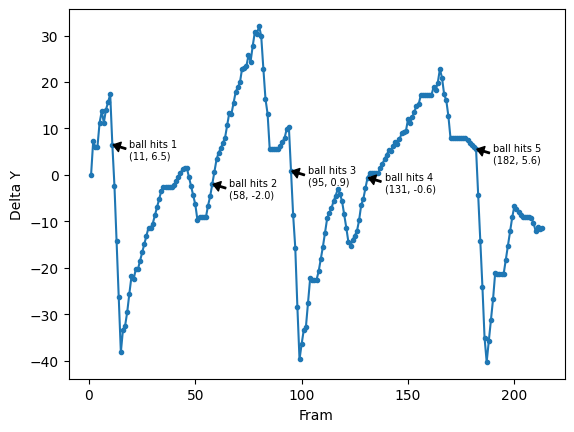

In [21]:
plt.plot(df_ball_positions['delta_y'], markersize="6", marker=".")
plt.xlabel('Fram')
plt.ylabel('Delta Y')
count = 0
for i in ball_hit_index:
    count += 1
    x, y = i, df_ball_positions['delta_y'].iloc[i]
    plt.annotate(f'ball hits {count}\n({x}, {y:.1f})',
                xy=(x, y),
                xytext=(x+8, y-3),
                arrowprops={'width':1,
                            'headlength':5,
                            'headwidth':7,
                            'facecolor':'#000',
                            'shrink':0.05},
                fontsize=7)
plt.show()